In [227]:
import thingspeak
import pandas as pd
import json
import ssl
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from  matplotlib import pyplot as plt
import numpy as np
import plotly.io as pio
import datetime
from sklearn.model_selection import train_test_split
import math
import seaborn as sn
from typing import Tuple
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

ssl._create_default_https_context = ssl._create_unverified_context



In [2]:
API_KEY = "ZRDS32VNQEEFSOF4"
CHANNEL_ID = "1361623"

fields = {
    "field2": "TEMP [C]", 
    "field3":"Relative humidity", 
    "field4":"PM1 [ug/m3]", 
    "field5":"PM2.5 [ug/m3]", 
    "field6":"PM10 [ug/m3]",
    "created_at" : "Date/time"
}

new_fields = {v : k for (k,v) in zip(fields.keys(), fields.values())}

In [3]:
def setup_plotly():
    pd.options.plotting.backend = 'plotly'

setup_plotly()


In [5]:
def get_thingspeak_data(id: str, api_key: str, nb_of_results: int = 8000, drop_entry_id: bool = True, save: bool = False) -> pd.DataFrame:
    time_zone = "UTC"
    url = f"https://thingspeak.com/channels/{id}/feed.csv?apikey={api_key}&results={nb_of_results}&timezone={time_zone}"
    
    df = pd.read_csv(url)
    df.replace(['None'], np.nan, inplace=True)
    df.rename(columns=fields, inplace=True)
    df["Date/time"] = pd.to_datetime(df["Date/time"])
    df["TEMP [C]"] = df["TEMP [C]"].astype("float32")
    df.set_index("Date/time", inplace=True)
    df.index = df.index.tz_convert("Europe/Paris")
    if save:
        df.to_csv('data/thingspeak_data.csv')
    df = df.assign(missing= np.nan)
    df.drop("missing", inplace=True, axis=1)
    df.drop("Relative humidity", axis=1, inplace=True)
    df.drop("PM1 [ug/m3]", axis=1, inplace=True)
    
    if drop_entry_id:
        df.drop('entry_id', axis=1, inplace=True)


    return df

In [7]:
def get_zue_data():
    df = pd.read_csv('data/nabel_data.csv', delimiter=";")
    df["Date/time"] = pd.to_datetime(df["Date/time"], format='%d.%m.%Y %H:%M')
    df["TEMP [C]"] = df["TEMP [C]"].astype("float32")
    df.set_index("Date/time", inplace=True)
    df.index = df.index.tz_localize("Europe/Paris", ambiguous="NaT", nonexistent="shift_backward")
    df = df.assign(missing= np.nan)
    df.drop("missing", inplace=True, axis=1)

    return df

In [8]:
def extract_time_series(df: pd.DataFrame):
    pm10_series = df.loc[:, "PM10 [ug/m3]"]
    pm25_series = df.loc[:, "PM2.5 [ug/m3]"]
    temperature_series = df.loc[:, "TEMP [C]"]
    precipitation_series = df.loc[:, "PREC [mm]"]

    return temperature_series, precipitation_series, pm25_series, pm10_series

In [9]:
def merge_datasets(df_zue: pd.DataFrame, df_ts: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_zue, df_ts])


In [10]:
def get_dataset(save: bool = True) -> pd.DataFrame: 
    df_zue = get_zue_data()
    df_ts = get_thingspeak_data(id=CHANNEL_ID, api_key=API_KEY, save=True) 
    df = merge_datasets(df_ts=df_ts, df_zue=df_zue)
    if save:
        df.to_csv('data/dataset.csv')
    return df

In [11]:
df = get_dataset()

In [28]:
df.plot(title='Dataset', width=1100)

In [21]:
corrMatrix = df.corr()
px.imshow(corrMatrix)


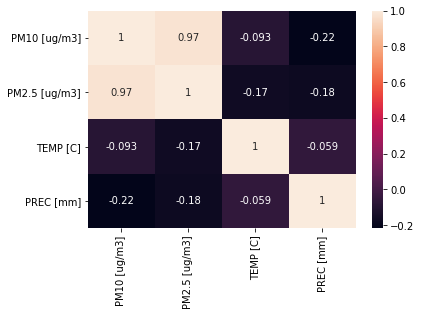

In [27]:
plt = sn.heatmap(corrMatrix, annot=True)
plt.get_figure().savefig('plots/correlogram.png')

In [29]:
temperature_series, precipitation_series, pm25_series, pm10_series = extract_time_series(df)

In [30]:
temperature_series.plot(title="Temperature time-series", width=1100)

In [31]:
precipitation_series.plot(title="Precipitation time-series", width=1100)

In [32]:
pm10_series.plot(title="PM10 time-series", width=1100)

In [20]:
pm10_series.interpolate(method='linear').plot(title="PM10 time-series", width=1100)

In [21]:
pm25_series.plot(title="PM2.5 time-series", width=1100)

In [ ]:
def compare_imputation_methods(df: pd.DataFrame)

    pass

In [17]:
def calc_percent_NAs(df: pd.DataFrame):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [18]:
calc_percent_NAs(df)

percent
PREC [mm]      0.216158
PM10 [ug/m3]   0.174486
TEMP [C]       0.001479
PM2.5 [ug/m3]  0.000269

In [248]:
def split_into_train_test_validation_sets(X: np.array) -> Tuple[np.array, np.array, np.array]:
    train_size = int(0.7 * len(X))
    validation_size = int(0.1 * len(X))
    test_size = len(X) - validation_size - train_size
    

    train_set, test_set, validation_set = X[0: train_size, :], X[train_size: train_size + test_size,:], X[train_size + test_size: train_size + test_size + validation_size, :]
    
    print(f"""
    Total dataset length: {len(X)}

    Number of features: {n_features}
    
    Train set shape: {train_set.shape} ({train_set.shape[0] / len(X) * 100:0.2f}% of dataset)
    Test set shape: {test_set.shape} ({test_set.shape[0] / len(X) * 100:0.2f}% of dataset)
    Validation set shape: {validation_set.shape} ({validation_set.shape[0] / len(X) * 100:0.2f}% of dataset)
    """)

    return train_set, test_set, validation_set

In [87]:
def normalize_dataset(df: pd.DataFrame) -> Tuple[np.array, MinMaxScaler]:
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    return (scaler.fit_transform(df), scaler)

In [46]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
        for j in range(n_vars):
		    names += [('var%d(t-%d)' % (j+1, i))]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [314]:
data = get_dataset()

values = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)
reframed = series_to_supervised(scaled_data, 1, 1)
print(reframed.shape)
reframed.drop(reframed.columns[[4,6,7]], axis=1, inplace=True)
print(reframed.head())
n_features = len(reframed.columns)

train_set, test_set, validation_set = split_into_train_test_validation_sets(X=reframed.values)

train_X, train_y = train_set[:, :-1], train_set[:, -1]
test_X, test_y = test_set[:, :-1], test_set[:, -1]
validation_X, validation_y = validation_set[:, :-1], validation_set[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)

(4528, 8)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var2(t)
1   0.011307   0.012995   0.563725        0.0  0.011551
2   0.010836   0.011551   0.566176        0.0  0.009385
3   0.011307   0.009385   0.563725        0.0  0.010107
4   0.009894   0.010107   0.561275        0.0  0.010107
5   0.010365   0.010107   0.553922        0.0  0.011551

    Total dataset length: 4528

    Number of features: 5
    
    Train set shape: (3169, 5) (69.99% of dataset)
    Test set shape: (907, 5) (20.03% of dataset)
    Validation set shape: (452, 5) (9.98% of dataset)
    
(3169, 1, 4) (3169,) (907, 1, 4) (907,) (452, 1, 4) (452,)


In [315]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

epochs = 500

history = model.fit(
    train_X, train_y, 
    epochs=epochs, 
    batch_size=72, 
    validation_data=(validation_X, validation_y), 
    verbose=2, 
    shuffle=False
)

poch 162/500
45/45 - 0s - loss: 0.0095 - val_loss: 0.0084
Epoch 163/500
45/45 - 0s - loss: 0.0095 - val_loss: 0.0086
Epoch 164/500
45/45 - 0s - loss: 0.0095 - val_loss: 0.0085
Epoch 165/500
45/45 - 0s - loss: 0.0095 - val_loss: 0.0086
Epoch 166/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 167/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 168/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 169/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0084
Epoch 170/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 171/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 172/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 173/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 174/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0084
Epoch 175/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 176/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 177/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.0085
Epoch 178/500
45/45 - 0s - loss: 0.0094 - val_loss: 0.008

In [305]:
# make a prediction
yhat = model.predict(test_X)

test_X_r = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_r[:, :-1]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y_r = test_y.reshape((len(test_y), 1))

inv_y = np.concatenate((test_y_r, test_X_r[:, :-1]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Validation RMSE: %.3f' % rmse)

Validation RMSE: 2.998


In [309]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var2(t)
1   0.015464   0.013772   0.600522        0.0  0.012242
2   0.014820   0.012242   0.603133        0.0  0.009946
3   0.015464   0.009946   0.600522        0.0  0.010712
4   0.013531   0.010712   0.597911        0.0  0.010712
5   0.014175   0.010712   0.590078        0.0  0.012242

In [301]:
px.line(x=np.arange(1, epochs + 1), y=[history.history["loss"], history.history["val_loss"]], width=1100, title="Training loss vs testing loss")

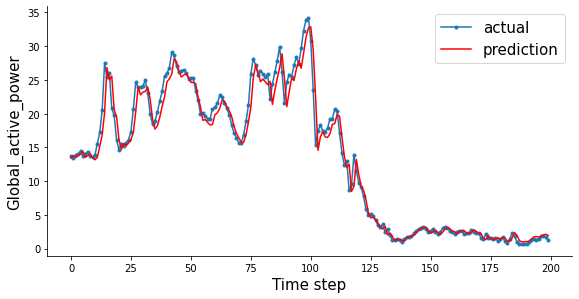

In [313]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sn.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()



In [322]:
px.line(x=np.arange(len(inv_y)), y=[inv_y[:-1], inv_yhat[1:], width=1100)

In [290]:
data.head()

PM10 [ug/m3]  PM2.5 [ug/m3]  TEMP [C]  PREC [mm]
Date/time                                                                  
2020-09-01 01:00:00+02:00           2.9            2.1      14.4        0.0
2020-09-01 02:00:00+02:00           2.8            1.9      14.5        0.0
2020-09-01 03:00:00+02:00           2.9            1.6      14.4        0.0
2020-09-01 04:00:00+02:00           2.6            1.7      14.3        0.0
2020-09-01 05:00:00+02:00           2.7            1.7      14.0        0.0